In [2]:
import sys
import numpy as np
import rescomp as rc
import networkx as nx
from scipy import sparse
from ipyparallel import Client
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import sklearn.gaussian_process as GP
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization as bopt

import warnings
warnings.filterwarnings("ignore")

## Set Up

In [15]:
# GET TRAINING AND TESTING SIGNALS
t, U = rc.orbit('lorenz', duration=150)
u = CubicSpline(t, U)
tr = t[:4000]
Utr = u(t[:4000])
ts = t[4000:]
Uts = u(t[4000:])  

In [4]:
def setres(my_dict, fix=False, scale=False):
    # OTHER PARAMS
    n = 500
    combo = 124750 ### ----- comb(500,2)
    c = 4

    # LOAD FROM DICTIONARY
    rho = my_dict['rho']
    pthin = my_dict['pthin']
    a = my_dict['a']
    g = my_dict['g']
    s = my_dict['s']

    if pthin == 1:
        res = rc.ResComp(sparse.dok_matrix(np.zeros((n,n))).tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
    else:
        # CREATE GRAPH
        A = nx.erdos_renyi_graph(n,c*(1-pthin)/(n-1),directed=True)
        A = sparse.dok_matrix(nx.adj_matrix(A).T)        

        if scale: # SCALE AND MAKE RESERVOIR
            scale_denom = np.abs(sparse.linalg.eigs(A.astype(float),k=1)[0][0])
            if scale_denom > 1e-10:
                B = A*(rho/scale_denom)
            res = rc.ResComp(B.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
        else:
            res = rc.ResComp(A.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
    res.train(tr, Utr)

    if fix:
        res.map_initial = 'activ_f'
    else:
        res.map_initial = 'relax'

    return res

In [5]:
rho_1p1_pthin_0p0 = {'rho': 1.1, 'pthin': 0.0, 'VPT': 3.629333333333335, 'a': 0.00827891588205206, 'g': 8.73362404864725, 's': 0.05446701798507083}
my_res = setres(rho_1p1_pthin_0p0)

## Metrics

### Consistency

In [6]:
def pearson_consistency_metric(states, states_perturbed):
    """ Compute the consistency metric for predicted states based on the Echo State Paper - Pearson Correlation Coefficient 
        Parameters:
        ----------
        states: ndarray(T,n)
            States using unperturbed initial state r0. T = time, n = number of nodes

        states_perturbed: ndarray(T,n)
            Perturbed states using perturbed initial state r0. T = time, n = number of nodes

        Returns:
        --------
        aggregated_pearson_correlation_coeff: float 
            The aggregated pearson correlation coefficient between the two response states
    """
    if len(states.shape) == 1:
        return pearsonr(states, states_perturbed)[0]
    else:
        T, n = states.shape
        gammas = np.zeros(n)
        for i in range(n):
            gammas[i] = pearsonr(states[:,i], states_perturbed[:,i])[0]
        # pearsonr is not defined for constant state vectors so nan will be returned - remove these from the array
        aggregated_pearson_correlation_coeff = np.mean(gammas[np.isfinite(gammas)])
        return aggregated_pearson_correlation_coeff

### Diversity

In [7]:
def div_metric_tests(states, T, n, combo):
    """ Compute Diversity scores of predictions
    """
    # Take the derivative of the pred_states
    res_deriv = np.gradient(states[:T], axis=0)

    # Run the metric for the old and new diversity scores
    div_abs = 0
    div_der = 0
    for i in range(n):
        for j in range(n):
            div_abs += np.sum(np.abs(np.abs(states[:T, i]) - np.abs(states[:T, j])))
            div_der += np.sum(np.abs(res_deriv[:T, i] - res_deriv[:T, j]))
    denom = T*combo
    div_abs = div_abs / denom
    div_der = div_der / denom

    return div_abs, div_der

## VPT and Plots

In [8]:
def valid_prediction_index(err, tol):
    """First index i where err[i] > tol. err is assumed to be 1D and tol is a float. If err is never greater than tol, then len(err) is returned."""
    mask = np.logical_or(err > tol, ~np.isfinite(err))
    if np.any(mask):
        return np.argmax(mask)
    return len(err)

def wa_vptime(ts, Uts, pre, vpttol=0.5):
    """
    Valid prediction time for a specific instance.
    """
    err = np.linalg.norm((Uts-pre), axis=1, ord=2)
    idx = valid_prediction_index(err, vpttol)
    if idx == 0:
        vptime = 0.
    else:
        vptime = ts[idx-1] - ts[0]

    return vptime

In [9]:
def plotit(Upred, res_states, pred_states, title=''):
    plt.figure(figsize=(12,3))
    
    # PLOT PREDICTION
    plt.subplot(131)
    plt.plot(ts[:1000], Uts[:1000,0], c='C0')
    plt.plot(ts[:1000], Uts[:1000,1], c='C0')
    plt.plot(ts[:1000], Uts[:1000,2], c='C0')
    plt.plot(ts[:1000], Upred[:1000,0], c='C1')
    plt.plot(ts[:1000], Upred[:1000,1], c='C1')
    plt.plot(ts[:1000], Upred[:1000,2], c='C1')
    plt.title('prediction for t > T')

    # PLOT RESPONSES [0,T]
    plt.subplot(132)
    for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
        plt.plot(tr[:1000], res_states[:1000, [i]], '-', color=c, alpha=0.8)
    # plt.ylim(-1.1,1.1)
    r0 = res_states[0]
    plt.scatter([tr[0]]*len(r0[:50]), r0[:50], c='k')
    plt.title(f'responses for t in [0,T]\n{np.round(np.min(res_states), 4)} to {np.round(np.max(res_states),4)}')
    
    # PLOT RESPONSES > T
    plt.subplot(133)
    for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
        plt.plot(ts[:1000], pred_states[:1000, [i]], '-', color=c, alpha=0.8)
    # plt.ylim(-1.1,1.1)
    plt.title(f'responses for t > T\n{np.round(np.min(pred_states), 4)} to {np.round(np.max(pred_states),4)}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## FIX r0

### My BHO Version

In [10]:

def waBHO(res):
    # GET RESPONSES
    r0 = res.initial_condition(Utr[0])
    res_states = res.internal_state_response(tr, Utr, r0)

    # GET VPT
    Upred, pred_states = res.predict(ts, r0=res.r0, return_states=True) # --- same as not specifying that r0=res.r0
    vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

    # PLOT
    plotit(Upred, res_states, pred_states, f'CORRECT\nr0=res.r0\nvpt = {vpt}')

    # return vpt

### Dallin Gridsearch Version

In [10]:
def Dallin(res):
    # GET RESPONSES
    r0 = res.initial_condition(Utr[0])
    res_states = res.internal_state_response(tr, Utr, r0)

    # GET VPT
    Upred, pred_states = res.predict(ts, r0=r0, return_states=True)
    vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

    # PLOT
    plotit(Upred, res_states, pred_states, f'INCORRECT\nr0 = res.initial_condition(Utr[0]))\nvpt = {vpt}')

    # return vpt

### PLOTS

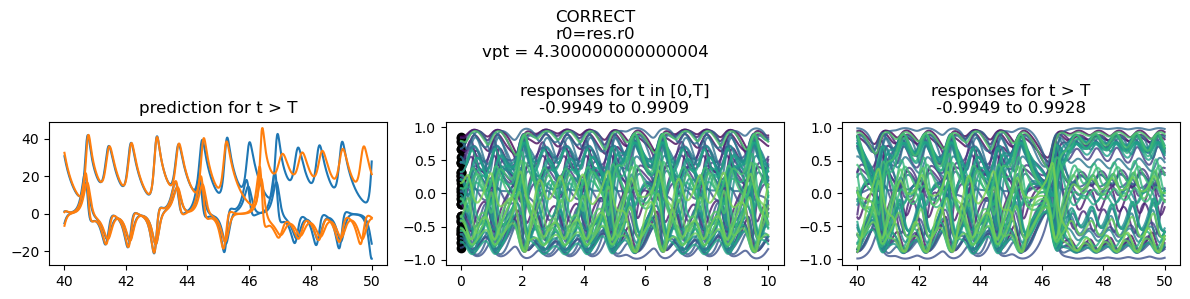

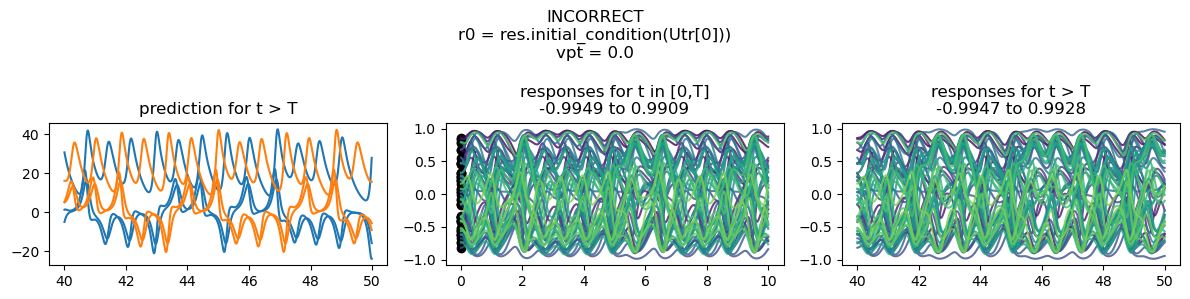

In [11]:
rho_1p1_pthin_0p0 = {'rho': 1.1, 'pthin': 0.0, 'VPT': 3.629333333333335, 'a': 0.00827891588205206, 'g': 8.73362404864725, 's': 0.05446701798507083}
res_1p1_0 = setres(rho_1p1_pthin_0p0)

waBHO(res_1p1_0)
Dallin(res_1p1_0)

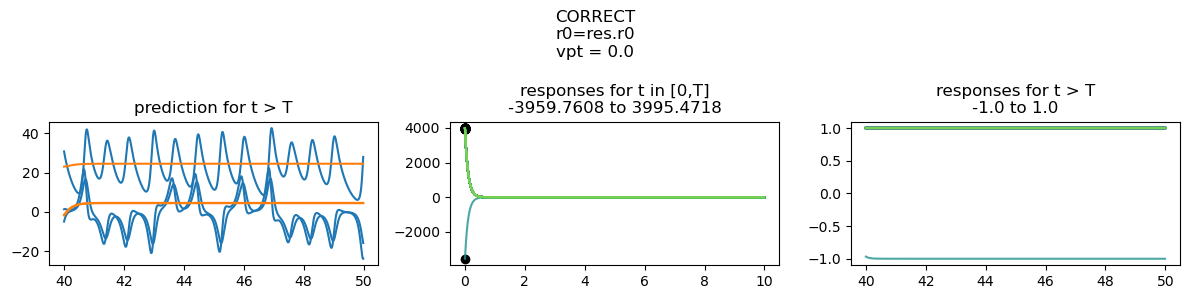

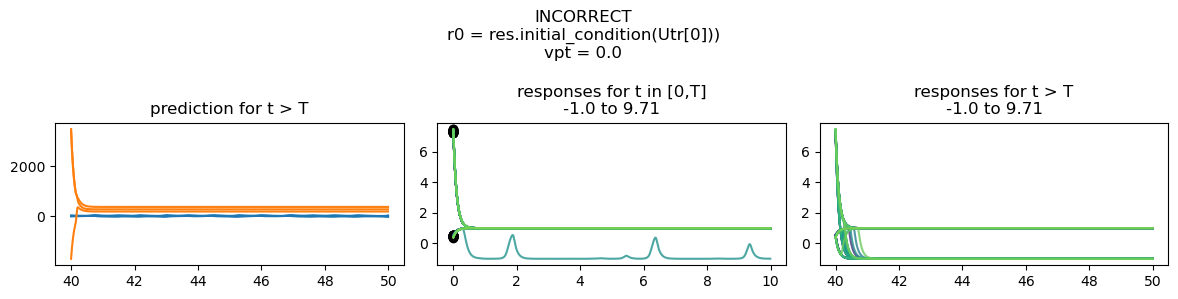

In [12]:
rho_50p0_pthin_0p0 = {'rho': 50.0, 'pthin': 0.0, 'VPT': 2.621153846153847, 'a': 0.001513057321386365, 'g': 9.720018818375697, 's': 0.2279795054489528}
res_50_0 = setres(rho_50p0_pthin_0p0)

waBHO(res_50_0)
Dallin(res_50_0)

### r0 vs res.r0 Demo

In [13]:
# GET RESPONSES
res = my_res
r0 = res.initial_condition(Utr[0])
res_states = res.internal_state_response(tr, Utr, r0)

# GET VPT
Upred, pred_states = res.predict(ts, r0=res.r0, return_states=True) # --- same as not specifying that r0=res.r0
vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

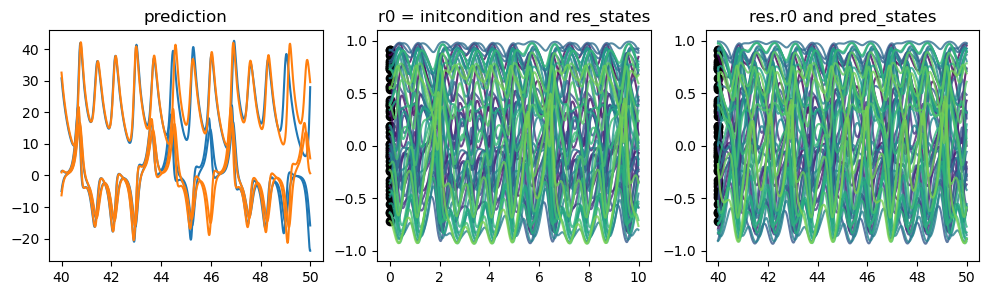

In [14]:
plt.figure(figsize=(12,3))
    
# PLOT PREDICTION
plt.subplot(131)
plt.plot(ts[:1000], Uts[:1000,0], c='C0')
plt.plot(ts[:1000], Uts[:1000,1], c='C0')
plt.plot(ts[:1000], Uts[:1000,2], c='C0')
plt.plot(ts[:1000], Upred[:1000,0], c='C1')
plt.plot(ts[:1000], Upred[:1000,1], c='C1')
plt.plot(ts[:1000], Upred[:1000,2], c='C1')
plt.title('prediction')

# PLOT RESPONSES [0,T]
plt.subplot(132)
for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
    plt.plot(tr[:1000], res_states[:1000, [i]], '-', color=c, alpha=0.8)
plt.ylim(-1.1,1.1)
plt.scatter([tr[0]]*len(r0[:50]), r0[:50], c='k')
plt.title('r0 = initcondition and res_states')

# PLOT RESPONSES > T
plt.subplot(133)
for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,50))):
    plt.plot(ts[:1000], pred_states[:1000, [i]], '-', color=c, alpha=0.8)
plt.ylim(-1.1,1.1)
plt.scatter([ts[0]]*len(res.r0[:50]), r0[:50], c='k')
plt.title('res.r0 and pred_states')

plt.show()

In [15]:
### ASSUME I'VE ALREADY TRAINED A MODEL

# GET RESPONSES
r0 = res.initial_condition(Utr[0])
res_states = res.internal_state_response(tr, Utr, r0)

# GET VPT
Upred, pred_states = res.predict(ts, r0=res.r0, return_states=True) # --- same as not specifying that r0=res.r0
vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

In [16]:
### THIS IS NODE STUFF AT t in [0,T]
print(r0[:6])
print(res_states[0,:6])
np.all(r0-res_states[0] == 0)

[ 0.57314041  0.86478348  0.32445708  0.01850631 -0.08471361  0.28315089]
[ 0.57314041  0.86478348  0.32445708  0.01850631 -0.08471361  0.28315089]


True

In [17]:
### THIS IS NODE STUFF AT t > T
print(res.r0[:6])
print(pred_states[0,:6])
np.all(res.r0-pred_states[0] == 0)

[ 0.86171739  0.30102923  0.71306151 -0.18087618 -0.78724157 -0.6267718 ]
[ 0.86171739  0.30102923  0.71306151 -0.18087618 -0.78724157 -0.6267718 ]


True

In [18]:
print(pred_states[0,:6]) ### BEGINNING OF PREDICTION STATES
print(res_states[-2,:6]) ### LINES UP WITH 2nd TO LAST NODE RESPONSE
np.all(res_states[-2,:6]-pred_states[0,:6] == 0)

[ 0.86171739  0.30102923  0.71306151 -0.18087618 -0.78724157 -0.6267718 ]
[ 0.86171744  0.30102927  0.71306158 -0.18087629 -0.78724174 -0.62677199]


False

## CHECK FOR PARAM INSANITY

In [11]:
# EXAMPLES
rho_1p1_pthin_0p0 = {'rho': 1.1, 'pthin': 0.0, 'VPT': 3.629333333333335, 'a': 0.00827891588205206, 'g': 8.73362404864725, 's': 0.05446701798507083}

rho_50p0_pthin_0p0 = {'rho': 50.0, 'pthin': 0.0, 'VPT': 2.621153846153847, 'a': 0.001513057321386365, 'g': 9.720018818375697, 's': 0.2279795054489528}

rho_50p0_pthin_0p9 = {'rho': 50.0, 'pthin': 0.9, 'VPT': 2.2568333333333346, 'a': 0.0038150056733363027, 'g': 16.470072504771654, 's': 0.24581307008326905}

rho_50p0_pthin_1p0 = {'rho': 50.0, 'pthin': 1.0, 'VPT': 2.365932203389831, 'a': 1e-08, 'g': 11.365709572525004, 's': 0.07163084988477066}

In [12]:
def test_it(res, title=''):
    # GET RESPONSES
    r0 = res.initial_condition(Utr[0])
    res_states = res.internal_state_response(tr, Utr, r0)

    # GET VPT
    Upred, pred_states = res.predict(ts, r0=res.r0, return_states=True) # --- same as not specifying that r0=res.r0
    vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

    # PLOT
    plotit(Upred, res_states, pred_states, title+f'\nvpt = {vpt}')

In [9]:
"""for _ in range(3):
    res = setres(rho_1p1_pthin_0p0)
    test_it(res, 'rho=1.1, pthin=0.0')"""

"for _ in range(3):\n    res = setres(rho_1p1_pthin_0p0)\n    test_it(res, 'rho=1.1, pthin=0.0')"

In [10]:
"""for _ in range(3):
    res = setres(rho_1p1_pthin_0p0)
    test_it(res, 'NONE\nrho=1.1, pthin=0.0')

for _ in range(3):
    res = setres(rho_1p1_pthin_0p0, fix=True)
    test_it(res, 'MAP\nrho=1.1, pthin=0.0')

for _ in range(3):
    res = setres(rho_1p1_pthin_0p0, scale=True)
    test_it(res, 'SCALE\nrho=1.1, pthin=0.0')

for _ in range(3):
    res = setres(rho_1p1_pthin_0p0, fix=True, scale=True)
    test_it(res, 'BOTH\nrho=1.1, pthin=0.0')"""

"for _ in range(3):\n    res = setres(rho_1p1_pthin_0p0)\n    test_it(res, 'NONE\nrho=1.1, pthin=0.0')\n\nfor _ in range(3):\n    res = setres(rho_1p1_pthin_0p0, fix=True)\n    test_it(res, 'MAP\nrho=1.1, pthin=0.0')\n\nfor _ in range(3):\n    res = setres(rho_1p1_pthin_0p0, scale=True)\n    test_it(res, 'SCALE\nrho=1.1, pthin=0.0')\n\nfor _ in range(3):\n    res = setres(rho_1p1_pthin_0p0, fix=True, scale=True)\n    test_it(res, 'BOTH\nrho=1.1, pthin=0.0')"

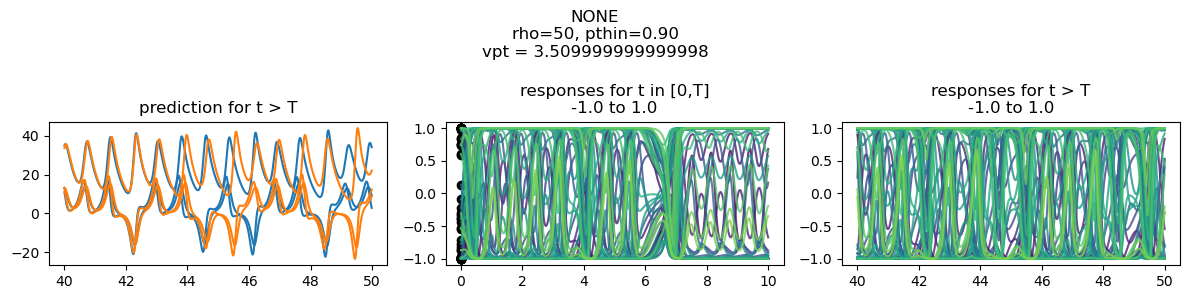

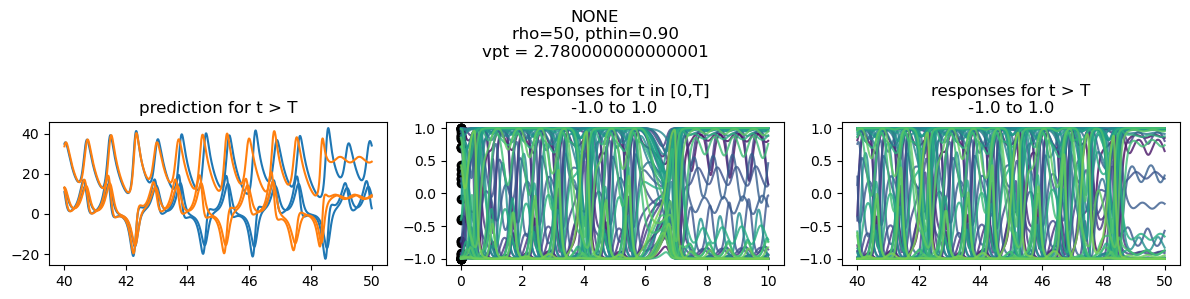

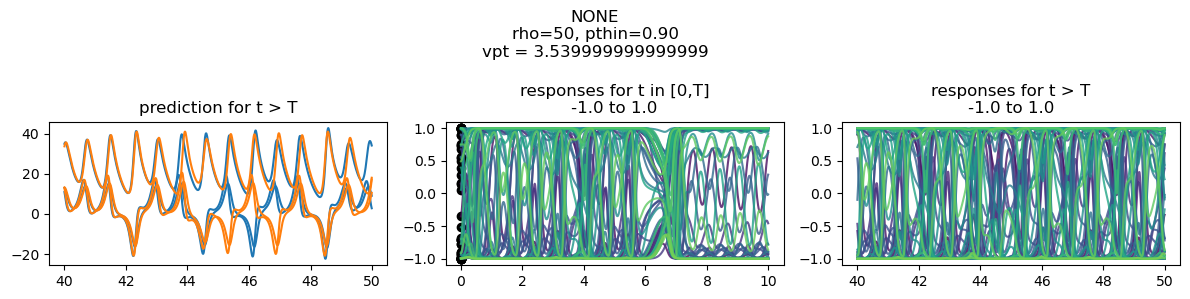

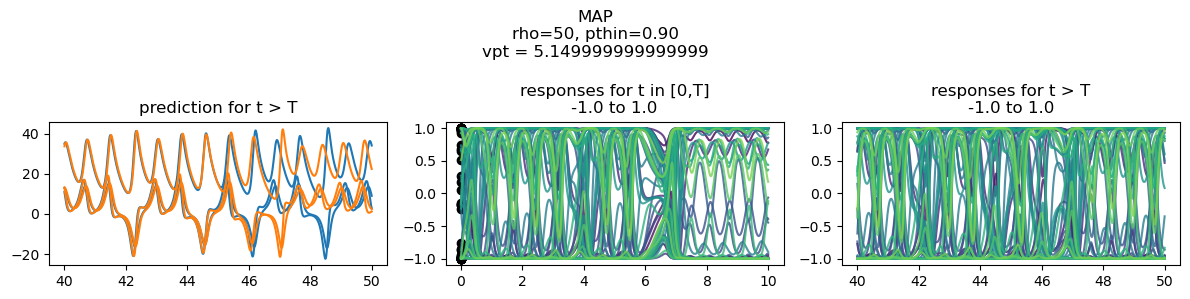

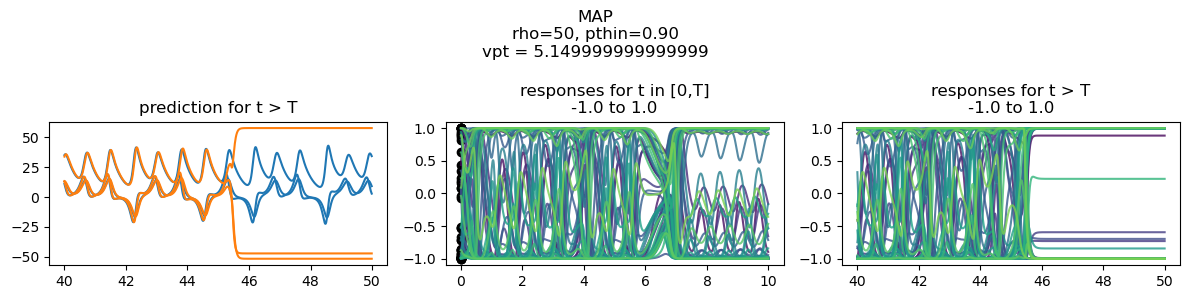

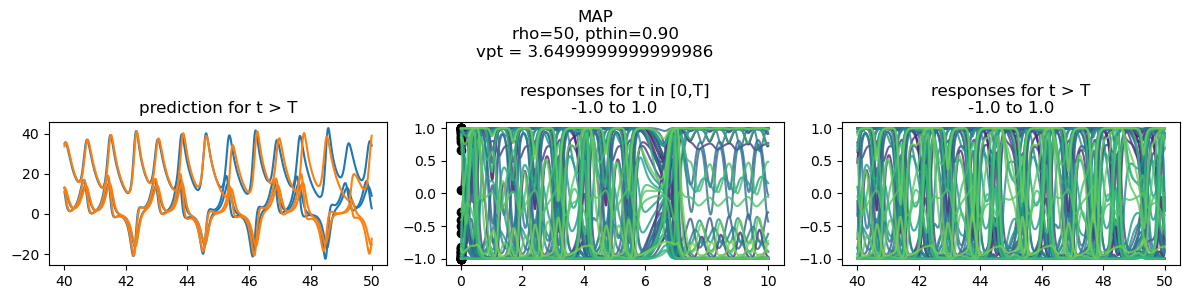

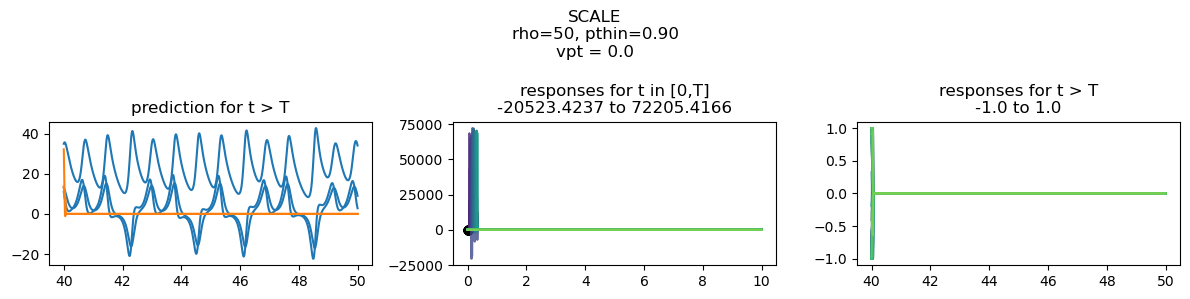

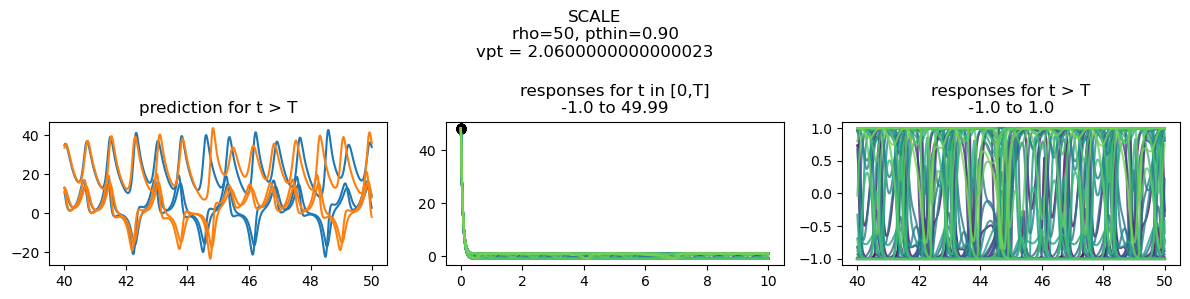

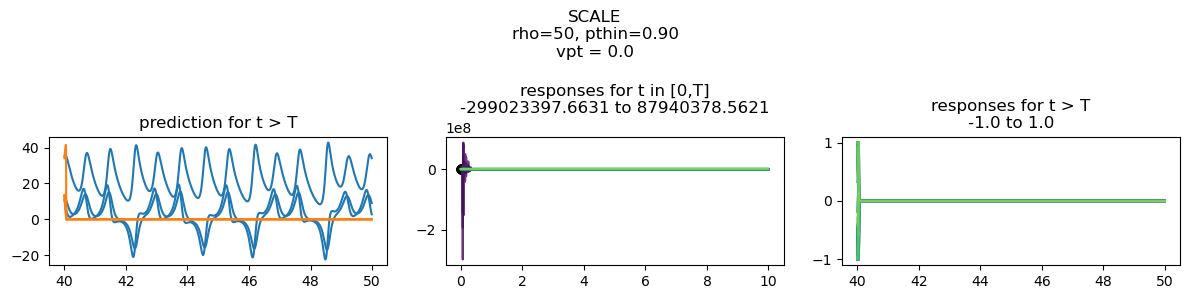

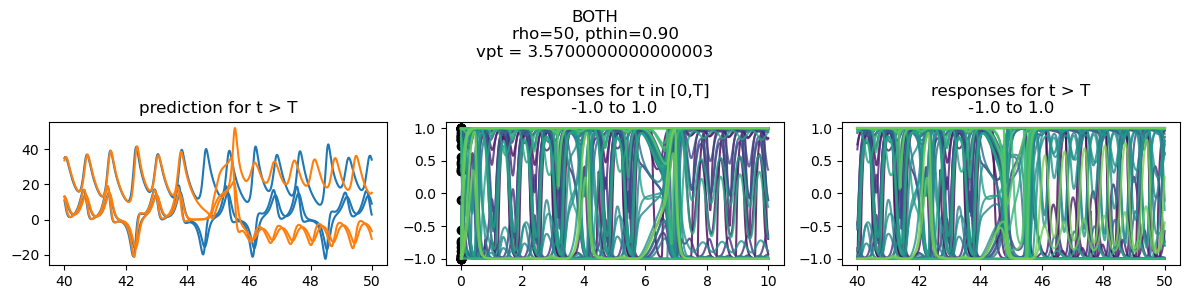

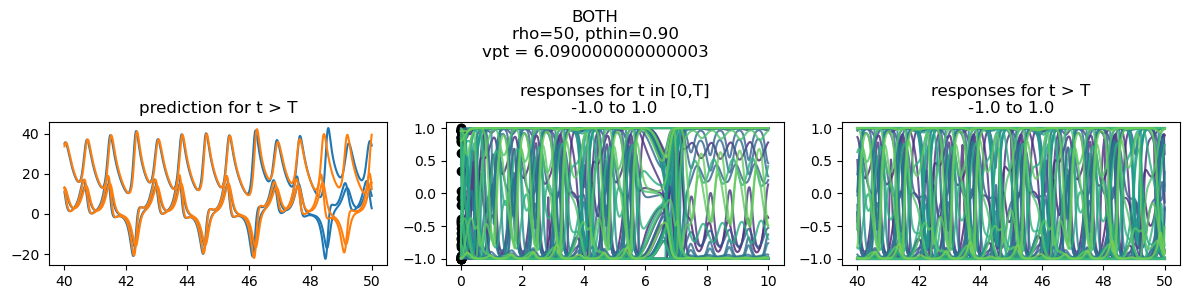

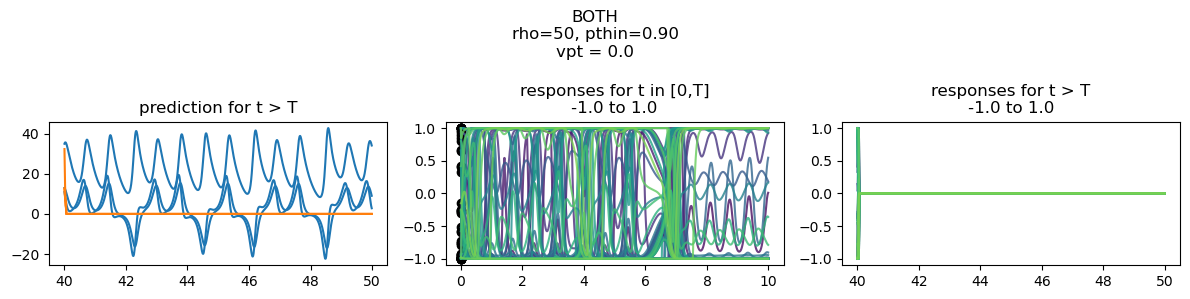

In [13]:
for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_0p9)
        test_it(res, 'NONE\nrho=50, pthin=0.90')
    except:
        pass

for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_0p9, fix=True)
        test_it(res, 'MAP\nrho=50, pthin=0.90')
    except:
        pass

for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_0p9, scale=True)
        test_it(res, 'SCALE\nrho=50, pthin=0.90')
    except:
        pass

for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_0p9, fix=True, scale=True)
        test_it(res, 'BOTH\nrho=50, pthin=0.90')
    except:
        pass

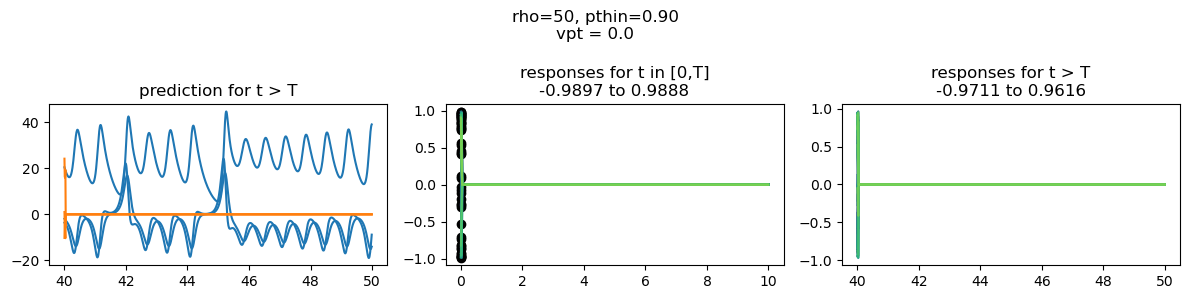

In [27]:
for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_0p9)
        test_it(res, 'rho=50, pthin=0.90')
    except:
        pass

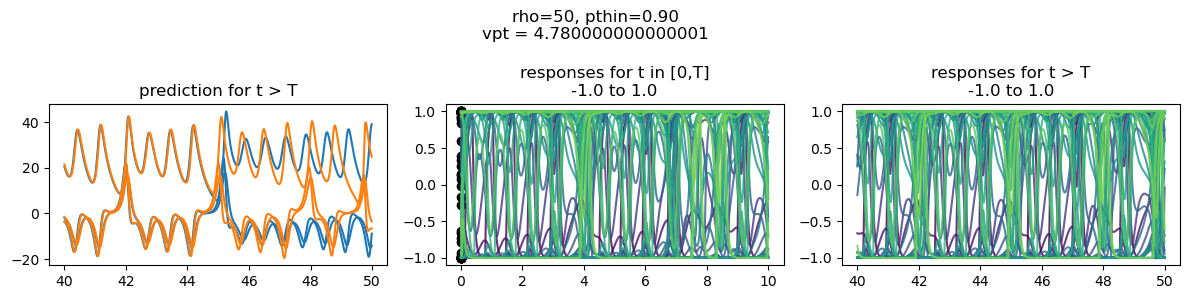

In [31]:
for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_0p9, fix=True)
        test_it(res, 'rho=50, pthin=0.90')
    except:
        pass

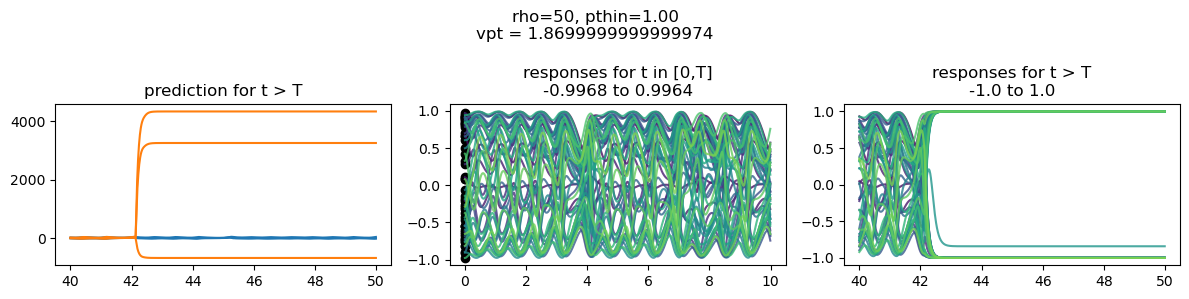

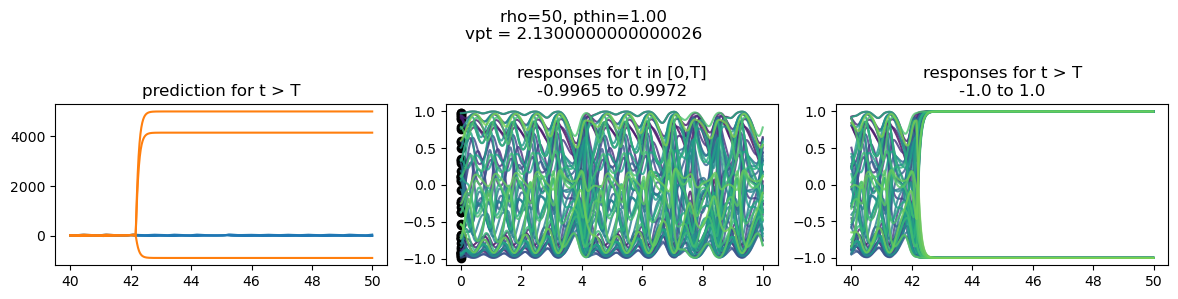

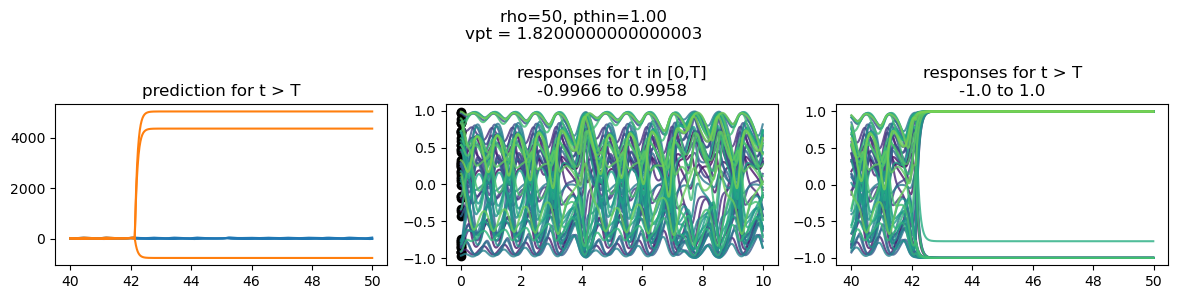

In [30]:
for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_1p0)
        test_it(res, 'rho=50, pthin=1.00')
    except:
        pass


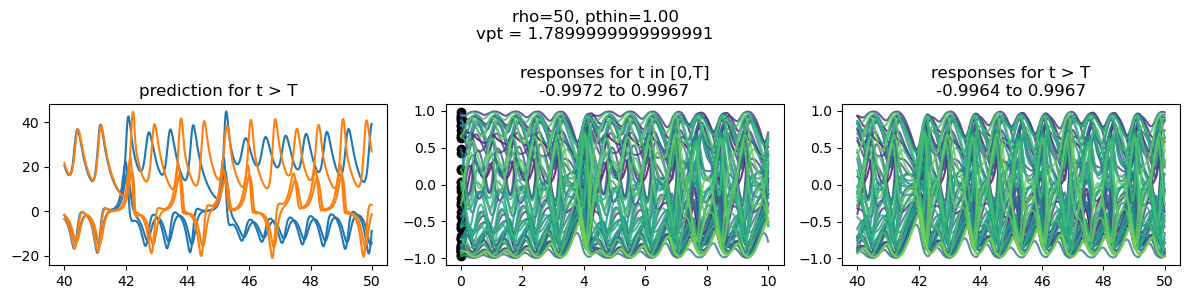

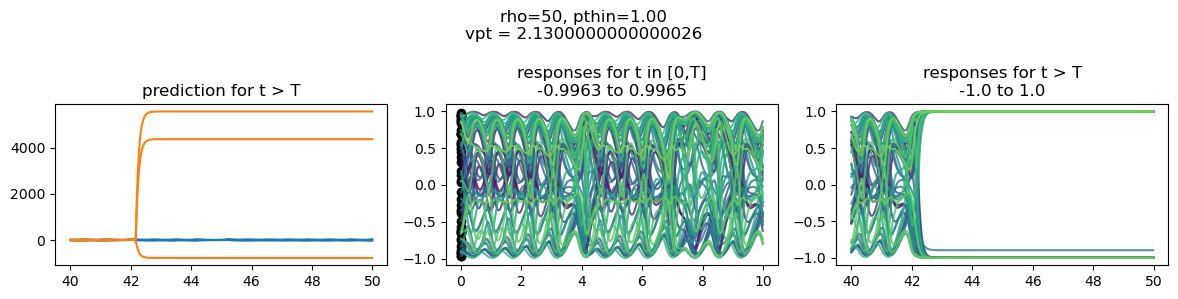

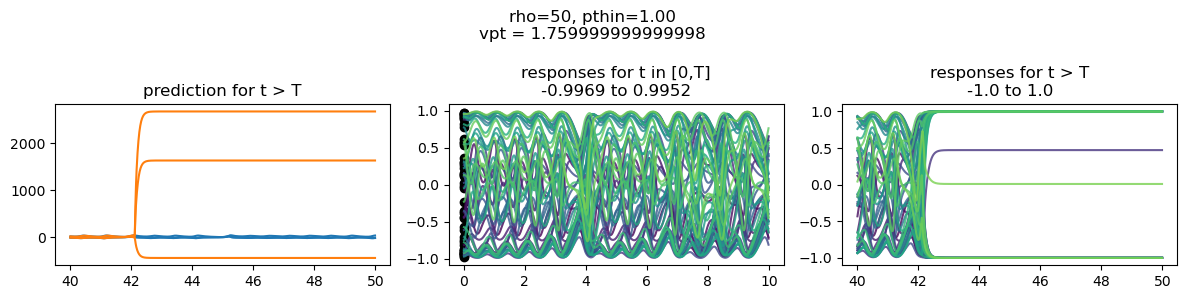

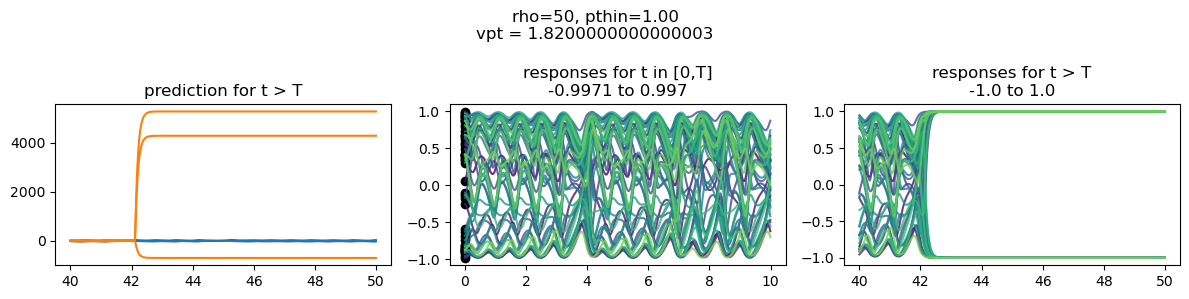

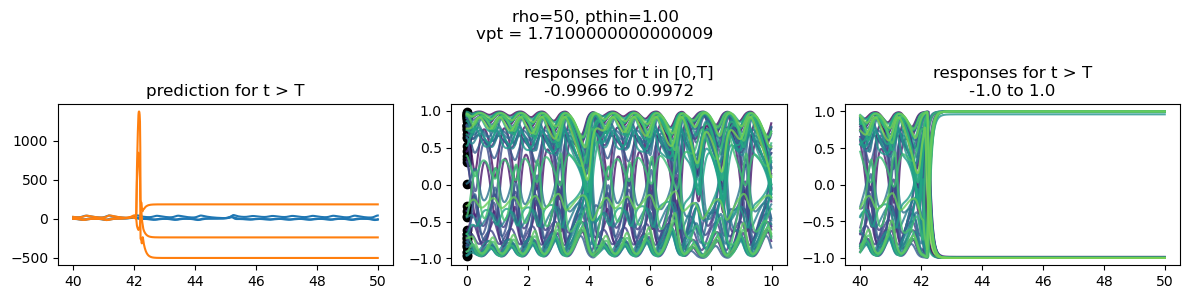

In [24]:
for _ in range(3):
    try:
        res = setres(rho_50p0_pthin_1p0, fix=True)
        test_it(res, 'rho=50, pthin=1.00')
    except:
        pass

In [14]:
my_res

In [17]:
Upred = my_res.predict(ts, r0=my_res.r0)